<div style="border:1px solid black; padding:20px 20px;text-align: justify;text-justify: inter-word">
   <strong> Basics of Mobile Robotics: Project Report <br/> Autumn 2021 <br/><br/> Group members: </strong><br/><br/> Henry Papadatos <br/> Juliette Pelissier <br/> Eliott Sizey<br/> Aitana Waelbroeck-Boix
    
    
</div>

# Introduction

### Environment

### State Machine


Our program starts by initialising the environment by analysing the first frame sent by the camera through the vision module. It determines the starting position of the Thymio, the corners of the obstacles and the center of the goals. The optimal path is then defined from those information in the path planning module. <br>
The program then enters into the main loop which follows 4 steps:
- Vision: Determines the pose (position + angle) of the Thymio using the images sent by the camera
- Kalman filter: 
- Local avoidance:
- Motion control: 

PUT STATE MACHINE GRAPH HERE

# Vision

### Principle

The goal of the vision part of the project is to map the environment in which the robot will move (obstacles and goals) and to keep track of its pose. Each element of the environment has a different color which allows color differentiation and localisation. From a frame captured by the camera, the most efficient way of doing color detection is to transform this frame from the BGR domain to the HSV domain and apply a range color filter that turns pixels in the range to white and the other pixels to black. Once this is done, the shapes of the detected objects are also used as described in the following subsections.
### HSV 

The HSV domain can be represented as a cone (figure 1 plotted below) and comprises three parameters that define a color: the hue, saturation and value. The hue is coded in the range [0,360] degrees accordingly to the corresponding angle in the color circle. The saturation corresponds to the intensity of the color and is comprised between 0% and 100%. The value is the "brilliance" of the color, the lower it is, the darker the color is. It is also defined between 0% and 100%. In the opencv library, the three parameters are coded in the following ranges:
- Hue: [0, 180]
- Saturation: [0, 255]
- Value: [0, 255]

The main advantage of using HSV color coding is that it is much easier to calibrate the range of the color filters as the saturation and value parameters make it much less dependent to the change of light on the map (lighting can be much less consistent than if using BGR color coding). In our project, we used three colors: blue for the obstacles, green for the goals and red for the Thymio which are coded in the following ranges ([H, S, V]):
- Blue: [0-20,50-255,0-255]
- Green: [50-70,50-255,50-255]
- Red: [115-130,50-255,50-255]

<img src='images report\HSV cone.png' alt="Modules" style="width: 400px;"/>

### Obstacles 

The creation and application of the range color filter is done using the function color_detection() for each object of the environment. The ranges of the HSV parameters for the In the top right image plotted below, we illustrate the result of using this function for the obstacles but it works similarly for the Thymio and the goals.

<IPython.core.display.Javascript object>


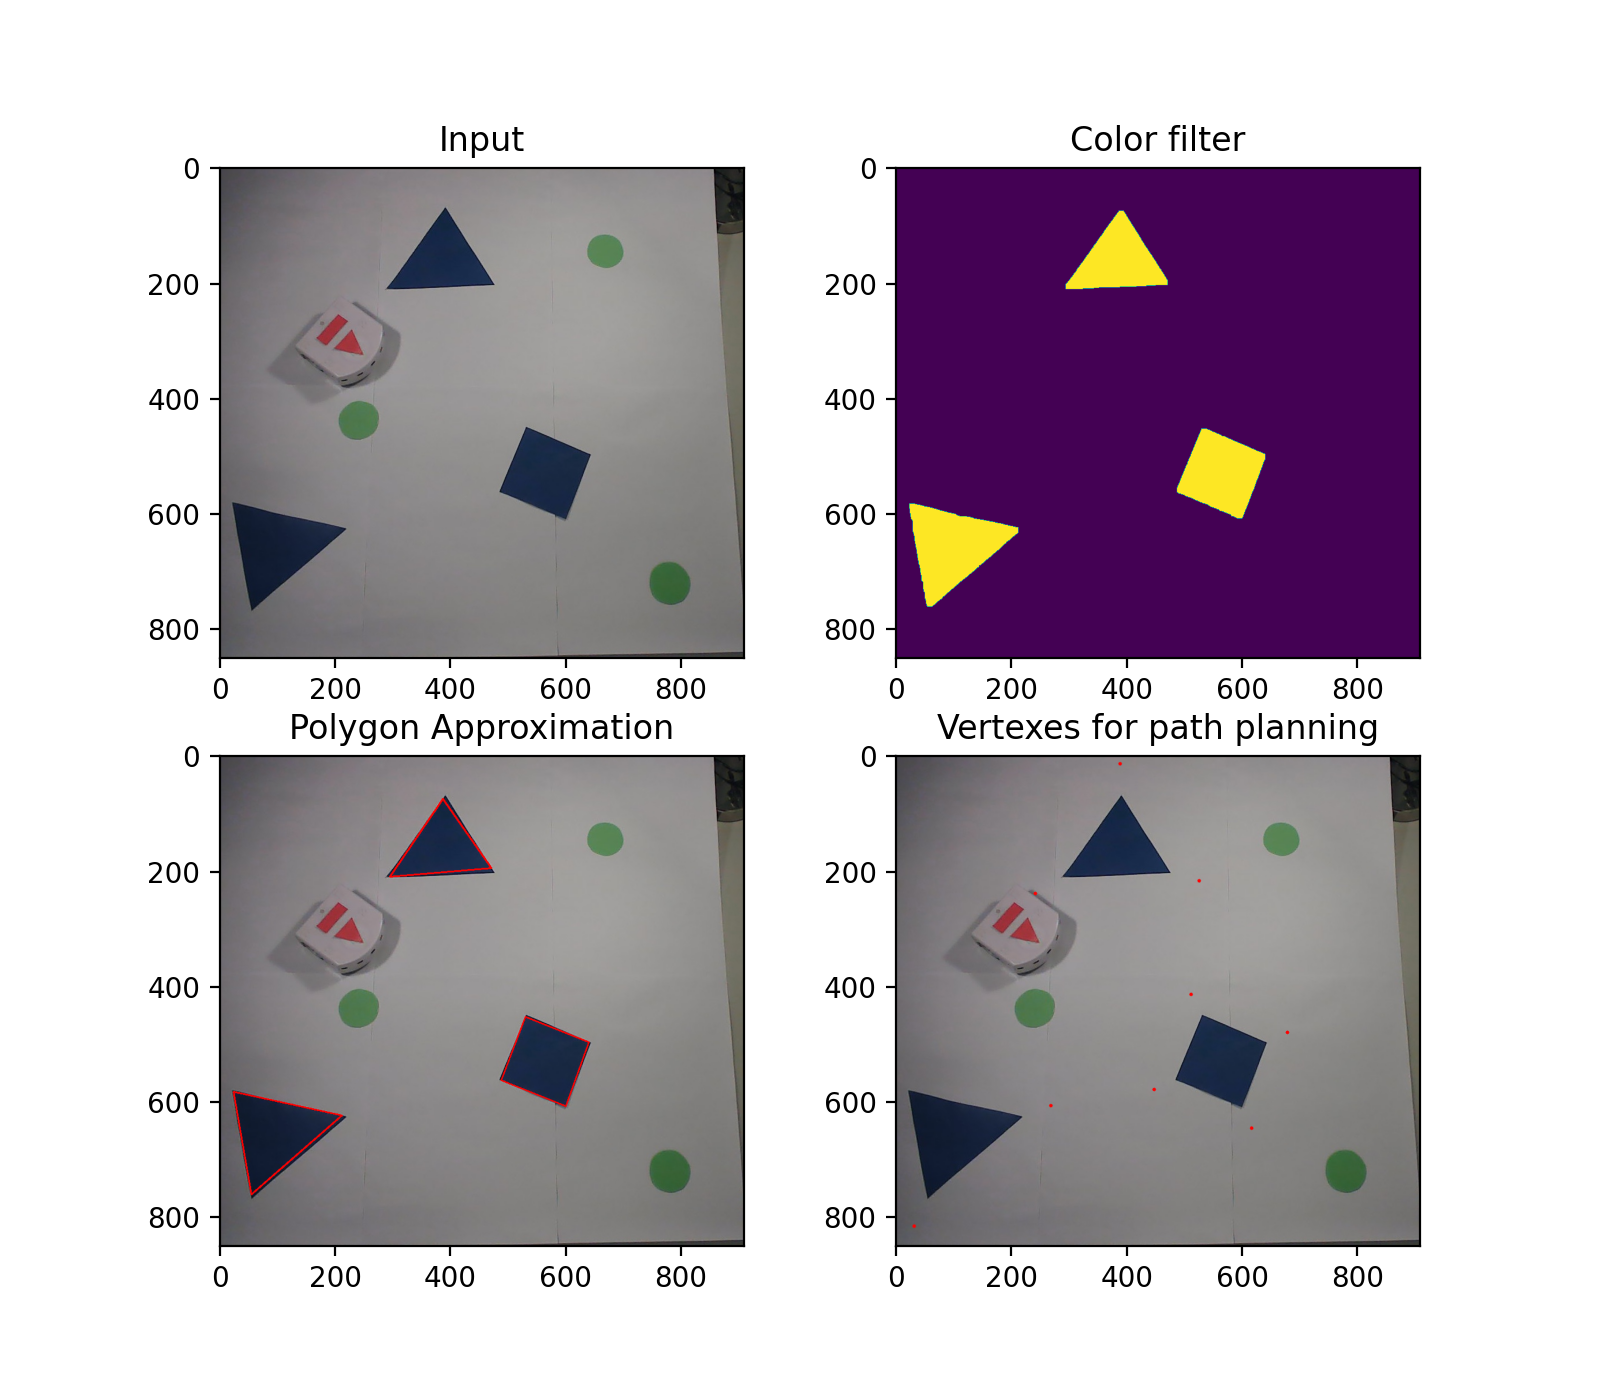

In [6]:
import cv2
import math
import numpy as np
%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook

SAFETY_FACTOR = 20 # margin so that the robot doesn't hit obstacles 
POLY_FACTOR_OBST = 0.05 # factor that determines how accurately the approxPolyDP function approximates
LEN_IN_MM = 113 # lenght of one side of the cube in mm

BLUE_LOW_H = 0
BLUE_HIGH_H = 20
BLUE_LOW_S = 50
BLUE_HIGH_S = 255
BLUE_LOW_V = 0
BLUE_HIGH_V = 255

def obstacles(img):
    # Extract obstacles from image "img", approximate them as polygons, find their corners and expand them
    
    # param pic : image captured by the camera
    
    # return new_corners : coordinates of the expanded obstacles corners
    # return Pix_to_mm : pixel to millimeter conversion factor
    # return img_goals : original image with black pixels except for the obstacles
    
    low_blue = np.array([BLUE_LOW_H, BLUE_LOW_S, BLUE_LOW_V])
    high_blue = np.array([BLUE_HIGH_H, BLUE_HIGH_S, BLUE_HIGH_V])
    corners=[]
    new_corners=[]
    centroids=[]
    img_contours=img.copy()
    img_final = img.copy()
    
    img_obst, mask_obst = color_detect(img, low_blue, high_blue)
    contours, hierarchy = cv2.findContours(mask_obst, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find largest area for noise condition
    areas = [cv2.contourArea(c) for c in contours]
    
    if not areas:
        cv2.imshow('mask', mask_obst)
        cv2.waitKey(0)
        raise ValueError("Can not read frame")
        
    max_cont = max(areas)
    
    # For each contour found, approximate it as a polygon and extract its corners
    for cont in contours:
        epsilon = POLY_FACTOR_OBST * cv2.arcLength(cont, True)
        approx = cv2.approxPolyDP(cont, epsilon, True)
        
        if(len(approx)>2 and cv2.contourArea(approx) >= max_cont/3): # Condition to get rid of detected noise 
            cv2.drawContours(img_contours, [approx], -1, (0, 0, 255), 2)
            corners.append(approx)
            if(len(approx) == 4): # Use rectangle obstacle to find the pixel to millimeter conversion factor
                Pix_to_mm = pix_to_mm(approx)
    
    # From extracted corners, define middle point of each object and create vertex (by 'expanding' corners)
    
    for i in range(0, len(corners)):
        centroids.append(centroid(corners[i]))
        new_corners.append(expand(centroids[i], corners[i], Pix_to_mm))   # Determine expanded corners (to take into account thymio width)    
    
        for corn in new_corners[i]:
            cv2.circle(img_final, corn, 3, (0, 0, 255) , -1)

    return new_corners, Pix_to_mm, mask_obst, img_final, img_contours

def color_detect(pic, low, high):
    # Extract color from the image "pic" based on the HSV color range [low-high]
    
    # param pic : image on which the color detection is conducted
    # param low : contains the lower values of the HSV parameters range
    # param high : contains the higher values of the HSV parameters range
    
    # return color_img : original image with black pixels except for the color detected
    # return mask : black and white color filter
    
    sigma = (5,5)
    
    image=cv2.blur(pic, sigma)                 # Blurring to get rid of image noise
    image=cv2.cvtColor(pic, cv2.COLOR_RGB2HSV) 
    mask=cv2.inRange(image, low, high)
    mask=cv2.erode(mask, None, iterations=4)    # Processing to have smoother color filter
    mask=cv2.dilate(mask, None, iterations=4)   

    color_img =cv2.bitwise_and(pic, pic, mask=mask)
    
    return color_img, mask

def expand(centroid, vertexes, px_factor):
    # Computes the expanded vertexes of a polygon based on the coordinates of its corners and centroid
    
    # param centroid : coordinates of centroid of obstacle 
    # param vertexes : corners coordinates of obstacle
    # param px_factor : pixel to millimeter conversion factor
    
    # return new_corners : coordinates of expanded corners
    
    
    half_thymio = SAFETY_FACTOR*(1/px_factor) # Thymio's half width - converted from mm to pixels
    if(len(vertexes) == 3): 
        expansion_dist = half_thymio/np.cos(np.pi/3) # For triangular obstacles
        
    else:
        expansion_dist = math.sqrt(2*half_thymio**2) # For rectangular obstacles
        
        
    new_corners = []
    
    for vertex in vertexes:
        dist = [(vertex[0][0] - centroid[0]), (vertex[0][1] - centroid[1])] # Distance between centroid and corner
        angle = np.arctan2(dist[1], dist[0])                                # Angle between centroid and corner
        new_coord = [vertex[0][0] + np.cos(angle)*expansion_dist, vertex[0][1] + np.sin(angle)*expansion_dist]
        new_corners.append(new_coord)
    
    new_corners = np.int0(new_corners)
    return new_corners

def centroid(vertexes):
    # Computes the coordinates of the centroid of a polygon given its corners coordinates
    
    # param vertexes : corners coordinates of polygon
    
    # return (x,y) : tuple of coordinates of the centroid of the polygon
    
    x_list = [vertex [0][0] for vertex in vertexes]
    y_list = [vertex [0][1] for vertex in vertexes]
    length = len(vertexes)
    x = np.int0(sum(x_list) / length)
    y = np.int0(sum(y_list) / length)
    
    return(x, y)

def pix_to_mm(rectangle):
    # Extract longest side of rectangle and computes pixel to millimeter conversion factor from it
    
    # param rectangle : coordinates of the corners of the rectangular obstacle
    
    # return px_to_mm : pixel to millimeter conversion factor
    
    len_in_px = 0
    
    for corn1 in rectangle:
        for corn2 in rectangle:
            if(np.any(corn1 != corn2)):
                dist = math.dist(corn1[0], corn2[0])
                if(dist > len_in_px):
                    len_in_px = dist

    px_to_mm = LEN_IN_MM/len_in_px
    
    return px_to_mm

img = cv2.imread('Images report/image_vision.jpg', cv2.IMREAD_COLOR)
vertexes, px_factor, mask, img_obst, img_contours = obstacles(img)
plt.figure(figsize=(8, 7))
plt.subplot(221),plt.imshow(img[:,:,::-1]),plt.title('Input')
plt.subplot(222),plt.imshow(mask),plt.title('Color filter')
plt.subplot(223),plt.imshow(img_contours[:,:,::-1]),plt.title('Polygon Approximation')
plt.subplot(224),plt.imshow(img_obst[:,:,::-1]),plt.title('Vertexes for path planning')
plt.show()

As can be seen from this figure, the obstacle() function does not only extract the obstacles from the image but it also find the corners of the obstacles and expand them in order to take into account the real size of the robot. This is done following those steps: 
- finding the contours of the color filter image
- approximating those contours as polygons (see image "Polygon approximation") and extracting their corners
- expanding the corners using the centroids() and expand() functions (see image "Vertexes for path planning" in which red dots represent the vertexes)

Another important feature of the obstacle() function is to calculate the pixel to millimeter conversion factor by dividing the measured length (113mm) of the longest side of the rectangle obstacle by its length in pixels. <br><br>

The distance by which the corners are expanded depends on the shape of the obstacle as we want to make sure that the robot doesn't hit the obstacle when going from one of its corners to an other. By doing simple trigonometry, we obtain that the expansion distance should be (as can bee seen on the figure below):
- Triangle : $dist_{expansion}$ = $\frac{width_{thymio}}{cos(60)}$
- Rectangle : $dist_{expansion}$ = $\sqrt{2 * \frac{width_{thymio}}{2}^2}$

<img src='images report\Expansion vision.jpg' alt="Modules" style="width: 400px;"/>

### Goals 

The center of the goals are defined in a very similar way. Once the contours are extracted from the color filter, the smallest enclosing circle is fitted to each goal and its center is returned. In the plot below, the centers of the goals are drawn as red dots.

<IPython.core.display.Javascript object>


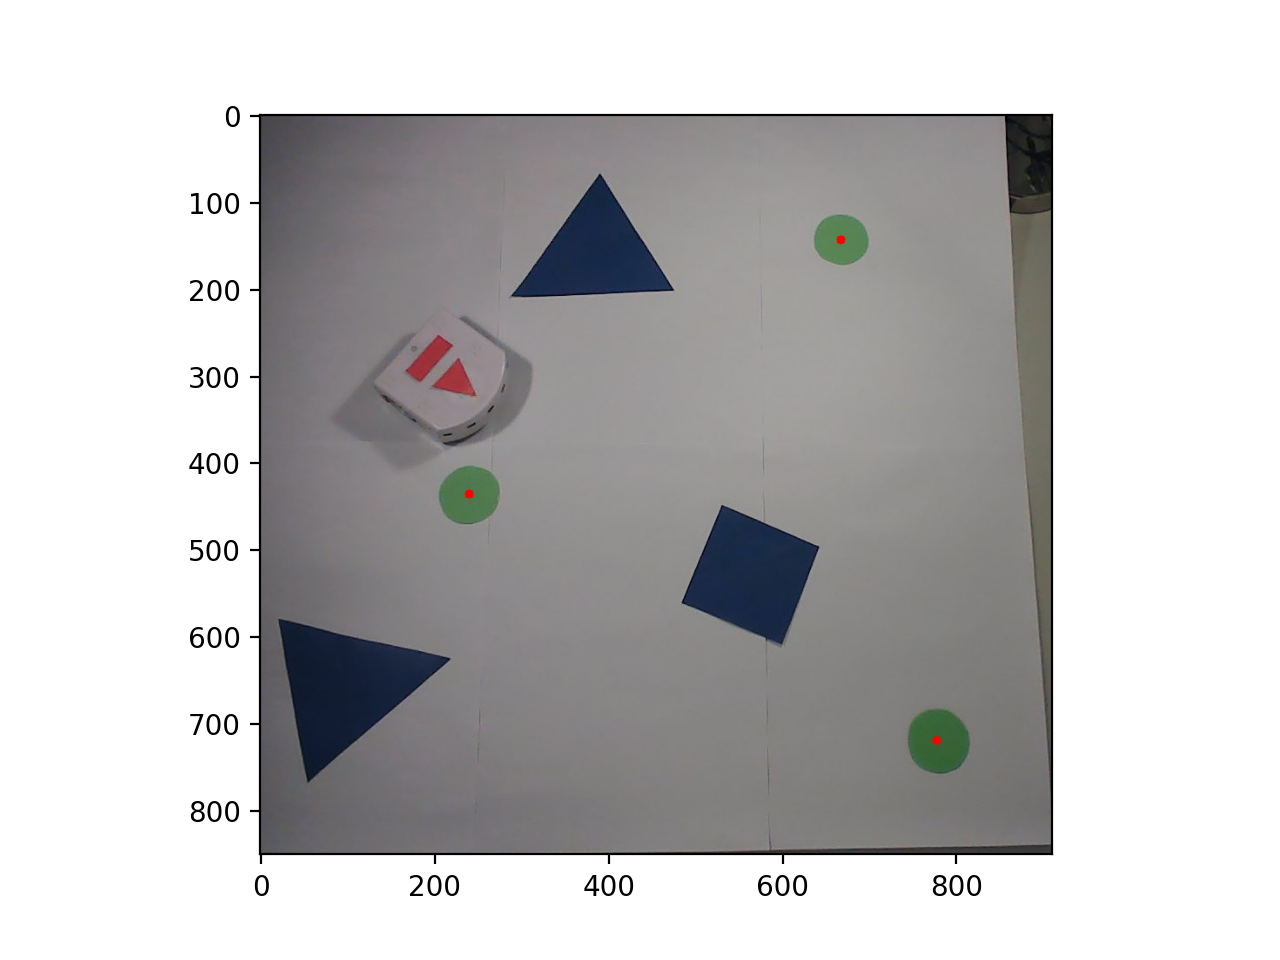

In [7]:
GREEN_LOW_H = 50
GREEN_HIGH_H = 70
GREEN_LOW_S = 50
GREEN_HIGH_S = 255
GREEN_LOW_V = 50
GREEN_HIGH_V = 255

def goals(pic):
    # Extract goals from image "pic" and find their centers
    
    # param pic : image captured by the camera
    
    # return goals_loc : coordinates of the centers of the goals
    # return img_goals : original image with black pixels except for the goals
    
    low_green = np.array([GREEN_LOW_H, GREEN_LOW_S, GREEN_LOW_V])
    high_green = np.array([GREEN_HIGH_H, GREEN_HIGH_S, GREEN_HIGH_V])

    goals_loc = []
    img_goals = pic.copy()
    
    # Extract goals from original image through color detection
    colored_mask, mask_goals = color_detect(pic, low_green, high_green)

    contours=cv2.findContours(mask_goals, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    
    # For each contour found, fit the minimum enclosing circle and extract center
    for cont in contours: 
        
        ((x, y), rayon)=cv2.minEnclosingCircle(cont)
        goals_loc.append(np.array([int(x),int(y)]))
        
    #draw centers of goals
    for cent in goals_loc:
        cv2.circle(img_goals, cent, 5, (0, 0, 255) , -1)
    
    return goals_loc, img_goals

goals_centers, img_goals = goals(img)
plt.figure()
plt.imshow(img_goals[:,:,::-1])

### Thymio 

The red rectangle placed on top of the Thymio is at the center of the wheels axis and is detected in the same way as the obstacles to determine the position of the robot. Thus, we won't describe this implementation. However, to have the full pose of the Thymio, we also need its orientation. This is made possible by the red triangle which allows to detect the position of a second point on the Thymio, from which the orientation can be calculated. Once the centers of the rectangle and triangle are computed, the angle is calculated using those two lines of code:

The arctan2() function returns an angle in the range $[-\pi, \pi]$ which is then converted to the $[0, \pi]$ range by doing modulo 2$\pi$. The angle obtained represents the clockwise orientation of the robot with respect to the horizontal axis of the camera and with origin at the center of the red rectangle (see representation below).
<img src='images report\Angle robot.jpg' alt="Modules" style="width: 400px;"/>

# Global Navigation

Expliquer path planning

Peut montrer ce que ça donne avec le module séparé du reste 

# Local Navigation

local avoidance

memory

# Filtering

Kalman

Commenter la decision expanded kalman or not

initialisation matrices/tuning

# Motion Control

PID : mapping position sur 180 degrés 

# Conclusion